> Introdução à Ciência dos Dados \
> Ciência da Computação – UFV/Florestal


* **Nome:** lucas takeshi, Jonathan Lopes, Matheus Silva
* **Matrícula:** 2665, 2666, 2649

----
# Importação dos Dados

In [1]:
### NÃO REMOVA ESSA CÉLULA! ####

!wget https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_lobby_stats_player.csv
!wget https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_medalha.csv
!wget https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_players.csv
!wget https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_players_medalha.csv

--2022-06-21 11:50:41--  https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_lobby_stats_player.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28373607 (27M) [text/plain]
Saving to: ‘tb_lobby_stats_player.csv’

tb_lobby_stats_play 100%[===================>]  27.06M   167MB/s    in 0.2s    

2022-06-21 11:50:42 (167 MB/s) - ‘tb_lobby_stats_player.csv’ saved [28373607/28373607]

--2022-06-21 11:50:42--  https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_medalha.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12

In [2]:
#### Não altere essa célula!!! ####
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
original_df_lobby = pd.read_csv('./tb_lobby_stats_player.csv')
original_df_players = pd.read_csv('./tb_players.csv')
df_l =original_df_lobby
df_p =original_df_players
#Informações de players
#df_p.info()
#tratando os dados de players
df_p = df_p.drop("flFacebook",axis=1)
df_p = df_p.drop("flTwitter",axis=1)
df_p = df_p.drop("flTwitch",axis=1)
df_p = df_p.drop("dtBirth",axis=1)
df_p['dtRegistration'] = pd.to_datetime(df_p['dtRegistration'], infer_datetime_format=True)
#Informações de players
df_p.info()
#Informações de lobby
#df_l.info()
#tratando os dados de lobby
df_l = df_l.drop("qtShots",axis=1)
df_l = df_l.drop("qtPlusKill",axis=1)
df_l = df_l.drop("dtCreatedAt",axis=1)
df_l = df_l.drop("qtHitRightLeg",axis=1)
df_l = df_l.drop("qtHitLeftLeg",axis=1)
df_l = df_l.drop("qtHitRightArm",axis=1)
df_l = df_l.drop("qtHitLeftAtm",axis=1)
df_l = df_l.drop("qtHitStomach",axis=1)
df_l = df_l.drop("qtHitChest",axis=1)
df_l = df_l.drop("qtHitHeadshot",axis=1)
df_l = df_l.drop("qtTk",axis=1)
df_l = df_l.drop("qtTkAssist",axis=1)
#Informações de lobby
df_l.info()
#criação de dados categóricos de acordo com cada parametro
#STATS na coluna de jogador junto com teste de hipotese para verificar se o player morre menos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2716 entries, 0 to 2715
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   idPlayer        2716 non-null   int64         
 1   descCountry     2716 non-null   object        
 2   dtRegistration  2716 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 63.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184152 entries, 0 to 184151
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   idLobbyGame     184152 non-null  int64  
 1   idPlayer        184152 non-null  int64  
 2   idRoom          184152 non-null  int64  
 3   qtKill          184152 non-null  int64  
 4   qtAssist        184152 non-null  int64  
 5   qtDeath         184152 non-null  int64  
 6   qtHs            184152 non-null  int64  
 7   qtBombeDefuse   184152 non-null  i

In [4]:
df_l['qtKill'].describe()

count    184152.000000
mean         19.113531
std           7.481041
min           0.000000
25%          14.000000
50%          19.000000
75%          24.000000
max          85.000000
Name: qtKill, dtype: float64

In [5]:
# Calcular kill por round
def kpr(kills, rounds):
  kpr = kills/rounds #quanto mais alto melhor 
  return kpr

def dpr(deaths, rounds): #quanto mais próximo de 0 melhor
  dpr = deaths/rounds
  return dpr


df_l.insert((df_l.shape[1]),"kpr",kpr(df_l['qtKill'], df_l['qtRoundsPlayed']),True)
df_l.insert((df_l.shape[1]),"dpr",kpr(df_l['qtDeath'], df_l['qtRoundsPlayed']),True)
df_l



,idLobbyGame,idPlayer,idRoom,qtKill,qtAssist,qtDeath,qtHs,qtBombeDefuse,qtBombePlant,qt1Kill,...,qtClutchWon,qtRoundsPlayed,descMapName,vlLevel,qtSurvived,qtTrade,qtFlashAssist,flWinner,kpr,dpr
0,1,1,1,5,1,16,2,0,0,3,...,0,17,de_mirage,10,1.0,2.0,0.0,0,0.294118,0.941176
1,2,1,2,24,3,18,6,0,4,9,...,1,27,de_nuke,9,8.0,1.0,0.0,1,0.888889,0.666667
2,3,2,3,6,4,23,2,0,1,4,...,0,25,de_mirage,2,2.0,3.0,0.0,0,0.240000,0.920000
3,3,391,27508,10,5,20,4,1,0,6,...,1,25,de_mirage,15,3.0,4.0,0.0,1,0.400000,0.800000
4,4,2,4,8,4,26,6,0,2,4,...,0,30,de_nuke,2,4.0,4.0,2.0,0,0.266667,0.866667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184147,172907,2716,178496,21,3,13,5,1,1,8,...,0,26,de_vertigo,9,11.0,0.0,0.0,1,0.807692,0.500000
184148,172908,2716,178497,15,1,22,5,0,1,11,...,0,29,de_nuke,9,7.0,5.0,0.0,1,0.517241,0.758621
184149,172909,2716,178498,9,6,23,2,0,3,9,...,0,27,de_vertigo,9,4.0,2.0,0.0,0,0.333333,0.851852
184150,172910,2716,178499,15,5,20,6,0,2,13,...,0,25,de_dust2,9,5.0,3.0,1.0,0,0.600000,0.800000


In [6]:
goodPlayers = df_l[df_l['kpr'] > 1]
mediaClutch = goodPlayers['qtClutchWon'].mean()
mediaClutch
veryGoodPlayers = goodPlayers[goodPlayers['qtClutchWon'] > mediaClutch]
veryGoodPlayers
#para categorizar e melhor fazer uma tabela de peso, em 100 pts quantos cada coluna vale? (qtAssist - 15, qtBombePlant - 15, qtBombeDefuse - 25, qtClutchWon - 25, qtTrade - 10, qtFlashAssist - 10)
#dessa forma pegamos e fazemos uma media ponderada acima da média seria excelente e abaixo seria muito bom
#correlacionar com dpr pois pode ser que esteja relacionado excelentes jogadores morrem menos
#correlacionar com dano


,idLobbyGame,idPlayer,idRoom,qtKill,qtAssist,qtDeath,qtHs,qtBombeDefuse,qtBombePlant,qt1Kill,...,qtClutchWon,qtRoundsPlayed,descMapName,vlLevel,qtSurvived,qtTrade,qtFlashAssist,flWinner,kpr,dpr
37,36,3,36,32,4,14,14,2,2,9,...,1,24,de_nuke,15,9.0,3.0,0.0,1,1.333333,0.583333
77,72,3,72,33,4,19,16,0,2,7,...,1,29,de_dust2,13,10.0,5.0,2.0,1,1.137931,0.655172
94,88,3,88,35,2,19,11,2,1,9,...,2,29,de_nuke,14,6.0,4.0,0.0,1,1.206897,0.655172
102,96,3,96,30,1,21,11,0,1,11,...,1,28,de_dust2,14,5.0,3.0,1.0,0,1.071429,0.750000
117,110,439,31667,37,6,23,16,1,2,19,...,1,36,de_mirage,18,12.0,7.0,2.0,1,1.027778,0.638889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184014,172774,2712,178359,29,1,11,8,1,1,7,...,3,25,de_train,14,11.0,1.0,0.0,1,1.160000,0.440000
184055,172815,2712,178403,32,2,18,12,0,0,11,...,2,26,de_dust2,13,6.0,1.0,0.0,0,1.230769,0.692308
184058,172818,2712,178406,36,4,18,9,0,2,10,...,2,30,de_mirage,13,10.0,3.0,0.0,1,1.200000,0.600000
184093,172853,2714,178442,32,2,20,11,0,0,12,...,1,27,de_inferno,11,6.0,3.0,1.0,1,1.185185,0.740741


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 1.0, '')

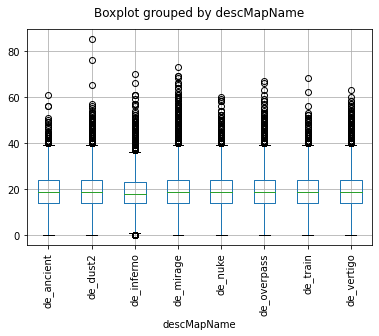

In [7]:
killPorMapa = df_l.boxplot(column='qtKill',by="descMapName", rot =90)
killPorMapa.set_title("")
#inconclusivo por enquanto, pois o mapa que tem mais kills também é o mapa mais jogado
#isso deve ser calculado com base na media de kills por partida 

In [21]:
x = df_l.groupby('descMapName')
y = x['qtKill'].count()
x['qtKill'].describe()
#MEDIA DE KILLS POR MAPA

,count,mean,std,min,25%,50%,75%,max
descMapName,,,,,,,,
de_ancient,4233.0,19.452870,7.568072,0.0,14.0,19.0,24.0,61.0
de_dust2,23834.0,18.970462,7.571573,0.0,14.0,19.0,24.0,85.0
de_inferno,42073.0,18.825327,7.260604,0.0,14.0,18.0,23.0,70.0
de_mirage,58101.0,19.139447,7.570700,0.0,14.0,19.0,24.0,73.0
de_nuke,14053.0,19.340710,7.426510,0.0,14.0,19.0,24.0,60.0
de_overpass,14088.0,19.291241,7.453231,0.0,14.0,19.0,24.0,67.0
de_train,7846.0,19.024981,7.575893,0.0,14.0,19.0,24.0,68.0
de_vertigo,19924.0,19.494579,7.541577,0.0,14.0,19.0,24.0,63.0


In [20]:
x = df_l.groupby('descMapName')
y = x['qtClutchWon'].count()
x['qtClutchWon'].describe()
#MEDIA DE CLUTCH POR MAPA

,count,mean,std,min,25%,50%,75%,max
descMapName,,,,,,,,
de_ancient,4233.0,0.499646,0.735003,0.0,0.0,0.0,1.0,6.0
de_dust2,23834.0,0.462365,0.710370,0.0,0.0,0.0,1.0,5.0
de_inferno,42073.0,0.442849,0.692001,0.0,0.0,0.0,1.0,8.0
de_mirage,58101.0,0.464674,0.709449,0.0,0.0,0.0,1.0,6.0
de_nuke,14053.0,0.496193,0.737793,0.0,0.0,0.0,1.0,7.0
de_overpass,14088.0,0.482538,0.725158,0.0,0.0,0.0,1.0,6.0
de_train,7846.0,0.475784,0.721596,0.0,0.0,0.0,1.0,5.0
de_vertigo,19924.0,0.509687,0.744844,0.0,0.0,0.0,1.0,8.0


In [28]:
x = df_l.groupby('descMapName')
y = x['kpr'].count()
x['kpr'].describe()

#MEDIA DE CLUTCH POR MAPA

,count,mean,std,min,25%,50%,75%,max
descMapName,,,,,,,,
de_ancient,4233.0,0.732977,0.242369,0.0,0.571429,0.720000,0.880952,1.888889
de_dust2,23834.0,0.717464,0.247417,0.0,0.550000,0.700000,0.866667,2.600000
de_inferno,42073.0,0.707308,0.235950,0.0,0.550000,0.692308,0.851852,3.000000
de_mirage,58101.0,0.723992,0.248233,0.0,0.555556,0.703704,0.875000,3.000000
de_nuke,14053.0,0.727166,0.237559,0.0,0.566667,0.714286,0.869565,2.400000
de_overpass,14088.0,0.726502,0.237959,0.0,0.566667,0.714286,0.869565,2.500000
de_train,7846.0,0.721588,0.248412,0.0,0.555556,0.704793,0.869565,3.000000
de_vertigo,19924.0,0.732112,0.242857,0.0,0.566667,0.720000,0.882353,3.000000


In [9]:
kill = df_l.qtKill.sum() #quantidade de kills do DataBase
flash = df_l.qtFlashAssist.sum()

flash/kill #porcentagem de kills que tiveram auxilio de flashs
#aproximadamente 2% das kills apenas tem assistencia de flashs

0.02970826425970831

In [ ]:
a = df_l.groupby('idLobbyGame')
a.count()

b = df_l[df_l['qtKill'] == 85]
b

,idLobbyGame,idPlayer,idRoom,qtKill,qtAssist,qtDeath,qtHs,qtBombeDefuse,qtBombePlant,qtTk,...,qtClutchWon,qtRoundsPlayed,descMapName,vlLevel,qtSurvived,qtTrade,qtFlashAssist,flWinner,kpr,dpr
127197,117343,1864,119819,85,17,63,31,0,2,0.0,...,2,84,de_dust2,20,19.0,11.0,2.0,0,1.011905,0.75


In [10]:
win = df_l['flWinner']>0
win.value_counts()

False    93224
True     90928
Name: flWinner, dtype: int64

In [11]:
temp = df_l[df_l['kpr']>1]
temp = temp[temp['qtClutchWon'] >= 1]
temp['qtClutchWon'].describe()


count    10611.000000
mean         1.470926
std          0.728301
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: qtClutchWon, dtype: float64

In [25]:
a = goodPlayers[['dpr', 'qtSurvived']]
b = goodPlayers[['vlDamage', 'qtKill']]


In [13]:
a.corr()

,dpr,qtSurvived
dpr,1.000000,-0.630881
qtSurvived,-0.630881,1.000000


In [14]:
b.corr()

,vlDamage,qtKill
vlDamage,1.000000,0.949359
qtKill,0.949359,1.000000
